## CNN - Example 

In [1]:
import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Dataset

In [3]:
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [4]:
zip_file = tf.keras.utils.get_file(origin=URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

In [5]:
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

### No classification classes

In [6]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

### Pre-Processing data in the FS

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images


Error: Destination path 'C:\Users\Amir\.keras\datasets\flower_photos\train\roses\10090824183_d02c613f10_m.jpg' already exists

### Train Test Split and FS

In [8]:
round(len(images)*0.8)

513

In [9]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [10]:
batch_size = 100
IMG_SHAPE = 150 

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [12]:
train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


### View non-augmented images

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [14]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

Note when loading data from folder
class_mode: One of "categorical", "binary", "sparse". "categorical" will be 2D one-hot encoded labels, 
"binary" will be 1D binary labels, "sparse" will be 1D integer labels.

In [16]:
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


### View augmented images

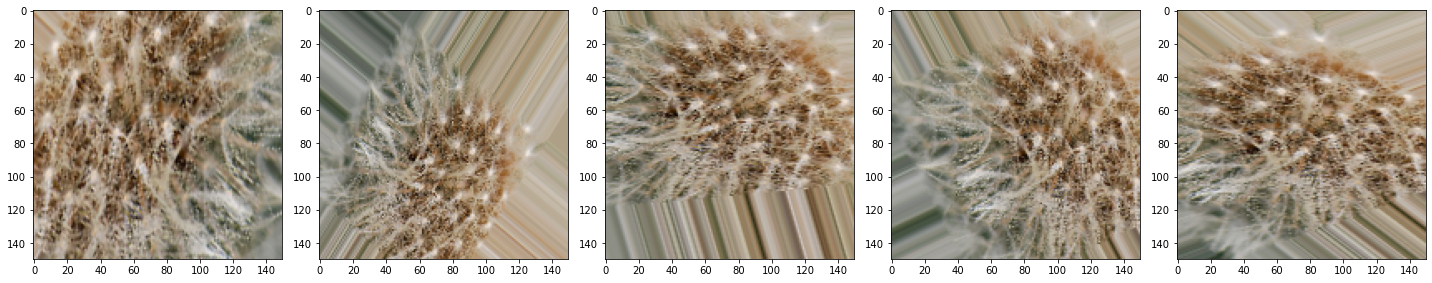

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [18]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [19]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


### Model # 1

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [22]:
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [23]:
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [24]:
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

In [25]:
model.add(Dropout(0.2))
model.add(Dense(5))     # default activation is a linear function a(x) = x

todo try :
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

Note from TF docs : Use SparseCategoricalCrossentropy loss function when there are two or more label classes. Like here where we have 5.

This is not for one hot coded : We expect labels to be provided as integers. 
If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss.

If softmax layer is not being added at the last layer then we need to have the from_logits=True to indicate the probabilities are not normalized. 

https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
epochs = 80

In [ ]:
history = model.fit(
# history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/80
30/30 [==============================] - ETA: 0s - loss: 1.5051 - accuracy: 0.3009

#### Evaluation 

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")
# plt.savefig('./foo.png')